In [1]:
from os.path import join
import json
import csv

import rpy2.rinterface
from pandas import read_csv, DataFrame, Series
from qiime2 import Artifact
from statsmodels.stats.weightstats import DescrStatsW
from IPython.display import Image

In [2]:
%reload_ext rpy2.ipython

In [3]:
%%R 
library(ggplot2)

In [4]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [5]:
abundances = read_csv(join(empo3_dir, 'abundances.tsv'), sep='\t')
abundances = abundances.set_index(['sample type', 'sample'])
eval_comp = read_csv(join(empo3_dir, 'eval_comp_results.tsv'), sep='\t')
eval_comp = eval_comp.join(abundances, ['sample type', 'sample'])

In [6]:
eval_comp = eval_comp[(eval_comp['sample type'] != 'single-strain') &
          (eval_comp['sample type'] != 'sterile-water-blank') &
          (eval_comp['sample type'] != 'mock-community') &
          (eval_comp['sample type'] != 'plant-surface')]
eval_comp = eval_comp[(eval_comp['class weights'] == 'bespoke70') |
          (eval_comp['class weights'] == 'uniform70') |
          (eval_comp['class weights'] == 'background') |
          (eval_comp['class weights'] == 'plant-corpus')]
level7 = eval_comp[eval_comp['level'] == 7]
level7 = level7[level7['abundance'] >= 1000]

In [7]:
grouped = level7.groupby(['sample type', 'class weights'])
def weighted_stats(x):
#    d1 = DescrStatsW(x['Bray-Curtis'], weights=x['abundance'])
    d1 = DescrStatsW(x['Bray-Curtis'])
    lower, upper = d1.tconfint_mean()
    return Series([d1.mean, lower, upper], index=['mean', 'lower', 'upper'])
figure2 = grouped.apply(weighted_stats)
figure2.reset_index(inplace=True)

In [8]:
old_labels = 'plant-corpus', 'background', 'uniform70', 'bespoke70'
new_labels = 'Wrong', 'Average', 'Uniform', 'Bespoke'
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['class weights'] == old, 'class weights'] = new
old_labels = [
    'animal-corpus',
    'animal-distal-gut',
    'animal-proximal-gut',
    'animal-secretion',
    'animal-surface',
    'plant-corpus',
    'plant-rhizosphere',
    'plant-surface',
    'sediment-non-saline',
    'soil-non-saline',
    'surface-non-saline',
    'water-non-saline',
    'sediment-saline',
    'surface-saline',
    'water-saline'
]
new_labels = [
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'
]
for old, new in zip(old_labels, new_labels):
    figure2.loc[figure2['sample type'] == old, 'sample type'] = new

In [9]:
%%R -i figure2
figure2$sample.type = factor(figure2$sample.type, levels=c(
    'Animal corpus',
    'Animal distal gut',
    'Animal proximal gut',
    'Animal secretion',
    'Animal surface',
    'Plant corpus',
    'Plant rhizosphere',
    'Plant surface',
    'Sediment (non-saline)',
    'Soil (non-saline)',
    'Surface (non-saline)',
    'Water (non-saline)',
    'Sediment (saline)',
    'Surface (saline)',
    'Water (saline)'))
figure2$class.weights = factor(figure2$class.weights, levels=c(
    'Wrong', 'Average', 'Uniform', 'Bespoke'
))
cbPalette <- c("#999999", "#56B4E9", "#E69F00", "#009E73", "#F0E442", "#0072B2", "#D55E00")
ggplot(data=figure2, aes(x=sample.type, y=mean, fill=class.weights)) +
  geom_bar(stat="identity", position=position_dodge()) +
  geom_errorbar(aes(ymin=lower, ymax=upper), position=position_dodge()) +
  coord_flip() +
  theme_bw() +
  theme(legend.position="bottom", 
        legend.direction="horizontal") +
  labs(x='EMPO3 Habitat', y='Bray-Curtis') +
  scale_fill_manual(values=cbPalette) +
  guides(fill=guide_legend(title="Taxonomic Weights", nrow=2, byrow=TRUE))
ggsave(file="figure2.png", width=5, height=10, dpi=300)

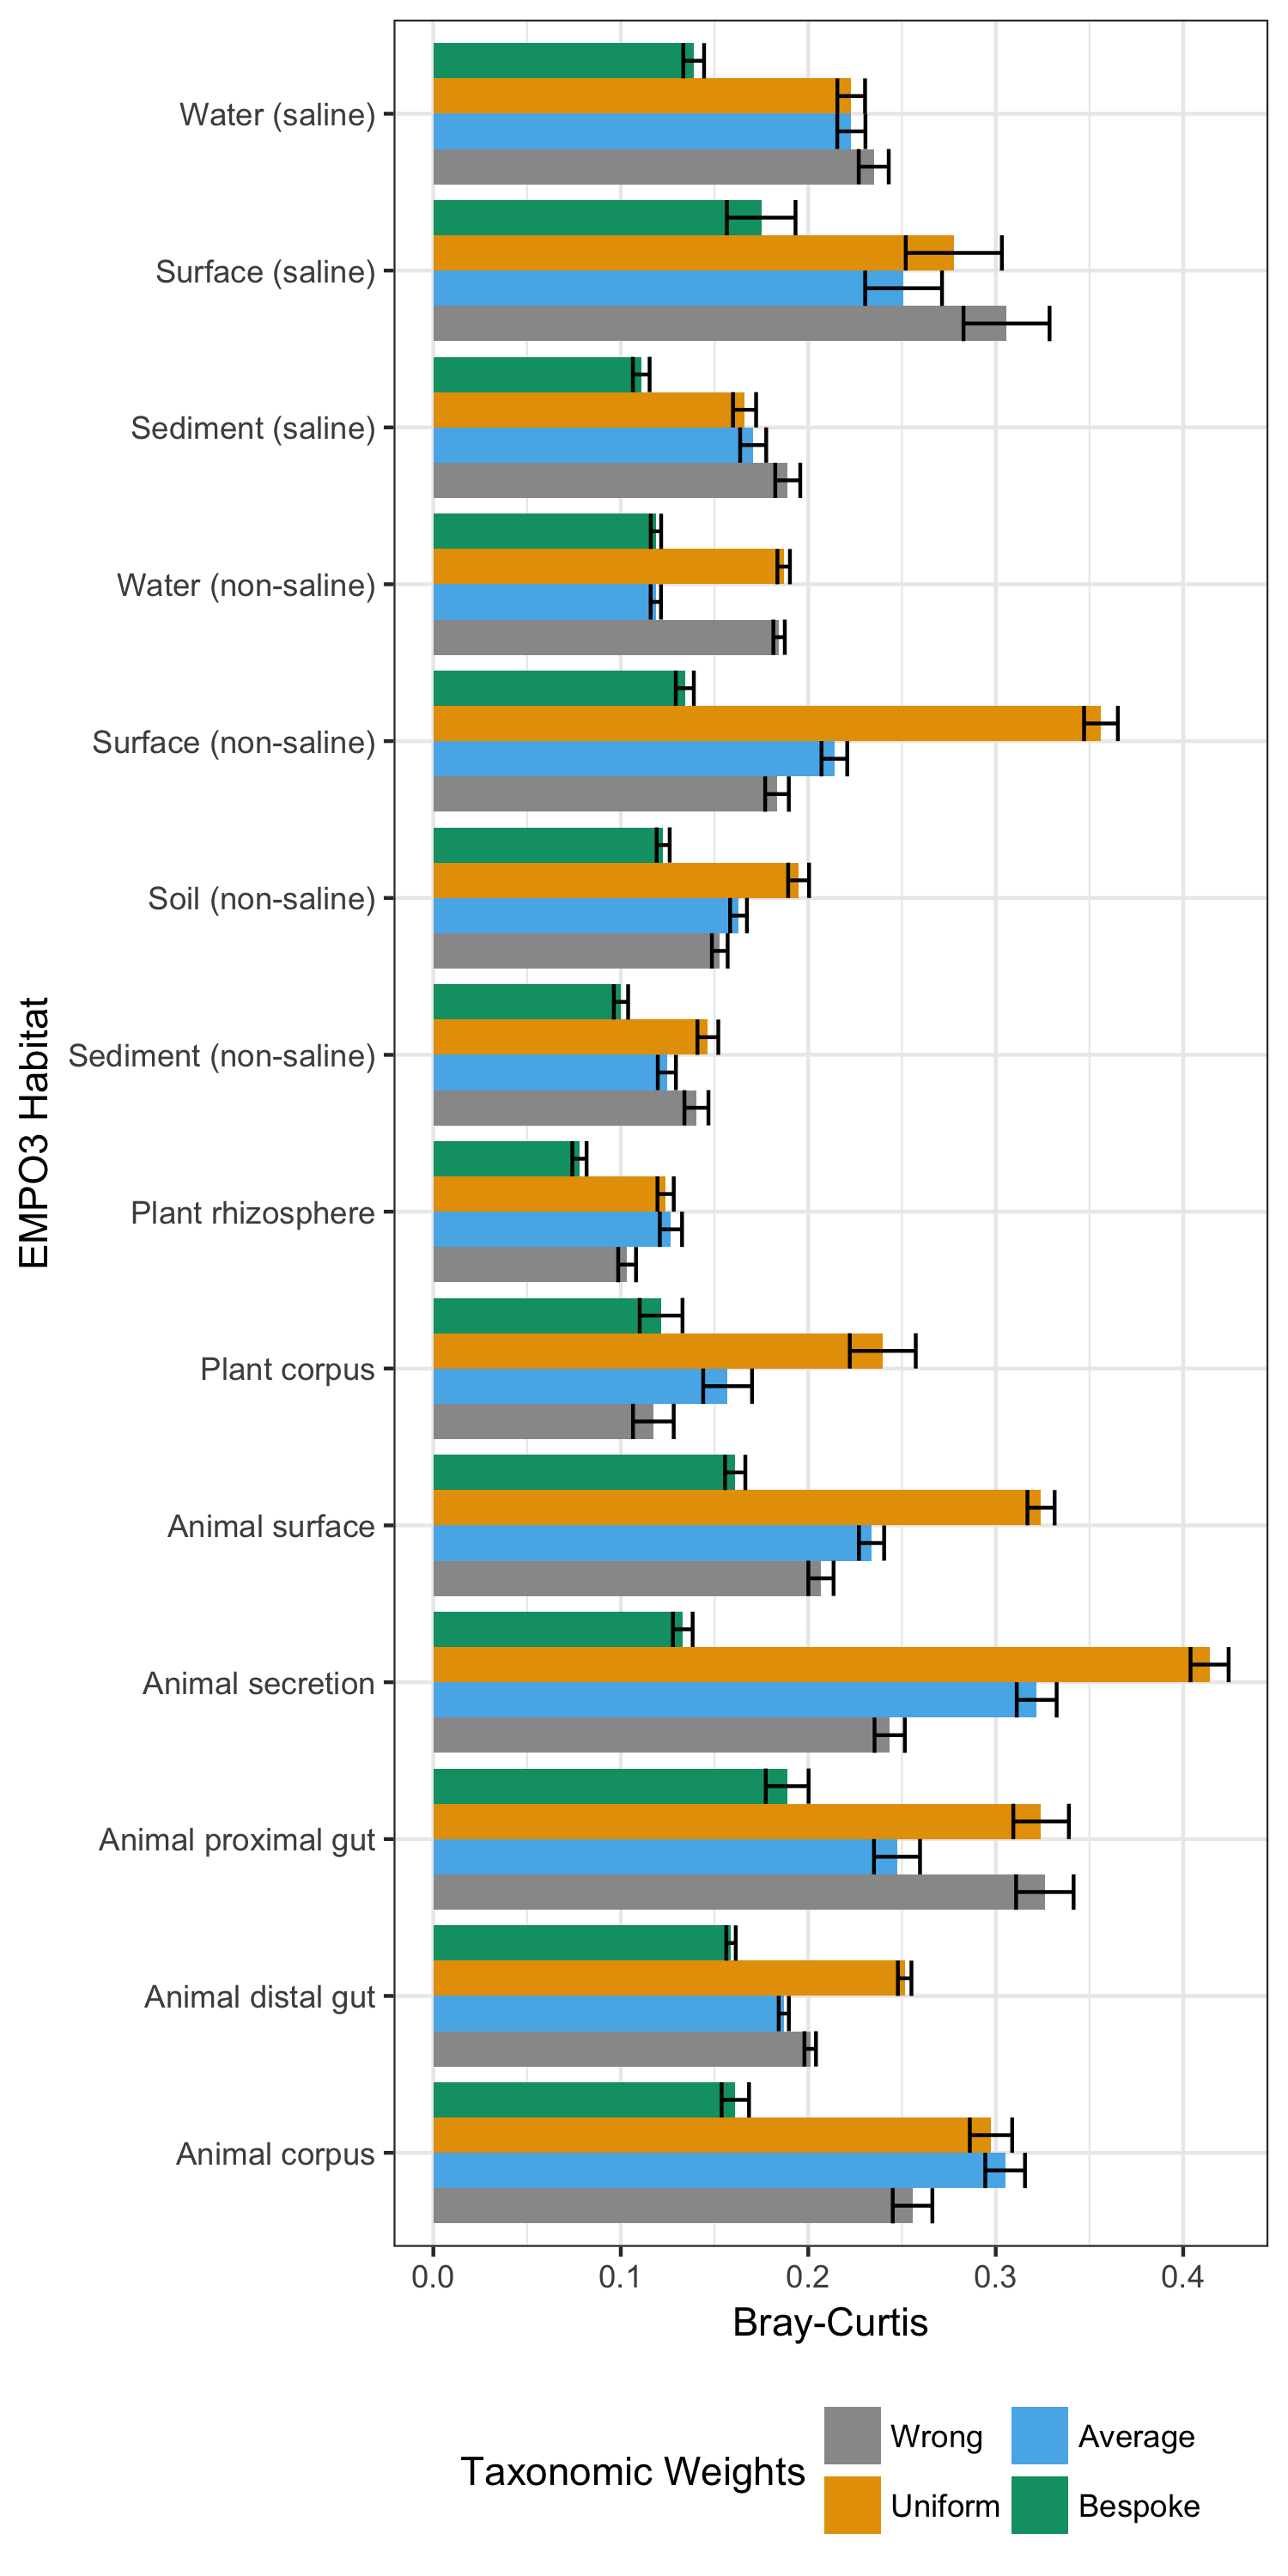

In [10]:
Image("figure2.png")

In [11]:
max(figure2['upper'] - figure2['lower'])

0.051278198503475925

In [12]:
figure2

,sample type,class weights,mean,lower,upper
0,Animal corpus,Average,0.305019,0.294422,0.315617
1,Animal corpus,Bespoke,0.161095,0.153794,0.168396
2,Animal corpus,Wrong,0.255635,0.245065,0.266206
3,Animal corpus,Uniform,0.297478,0.286181,0.308775
4,Animal distal gut,Average,0.186946,0.184238,0.189655
5,Animal distal gut,Bespoke,0.158792,0.156277,0.161307
6,Animal distal gut,Wrong,0.201030,0.197941,0.204119
7,Animal distal gut,Uniform,0.251434,0.247828,0.255041
8,Animal proximal gut,Average,0.247339,0.235064,0.259615
9,Animal proximal gut,Bespoke,0.188749,0.177318,0.200180


In [13]:
bespoke = figure2[figure2['class weights'] == 'Bespoke']['mean']
print(min(bespoke), max(bespoke))
uniform = figure2[figure2['class weights'] == 'Uniform']['mean']
print(min(uniform), max(uniform))

0.07794368748169657 0.18874874957410265
0.12390619871146612 0.4140814301354332


In [14]:
len(set(level7['sample']))

18222